# Imports

In [1]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import requests
import csv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertConfig
import h5py
from tqdm import tqdm
import os
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

2024-12-06 23:12:56.855946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733490776.996709  150544 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733490777.031121  150544 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 23:12:57.339425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

In [37]:
# Config

EXAMPLES_COUNT = 50000
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCH_COUNT=20

CLASS_COUNT=4

ALL_BATCHES = EXAMPLES_COUNT // BATCH_SIZE
TRAIN_BATCHES = int(ALL_BATCHES * 0.8)
TEST_BATCHES = (ALL_BATCHES - TRAIN_BATCHES) // 2
TEST_BATCHES = TEST_BATCHES

MAX_SEQ_LENGTH = 256

np.random.seed(RANDOM_SEED)

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [4]:
COLUMN_CATEGORY = 'category'
COLUMN_DESCRIPTION = 'description'

LOCAL_CSV_FILE_NAME = 'ecommerce-dataset.csv'
LOCAL_CSV_FILE_PATH = f'./{LOCAL_CSV_FILE_NAME}'

In [5]:
LABELS = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']

In [100]:
def load_data_to_csv():
    DATASET_URL = 'https://zenodo.org/record/3355823/files/ecommerceDataset.csv?download=1'
    
    df = pd.read_csv(DATASET_URL, names=[COLUMN_CATEGORY, COLUMN_DESCRIPTION], header=None, index_col=False)

    df.dropna()
    df.drop_duplicates()

    codes = df[COLUMN_CATEGORY].replace(['Household', 'Books', 'Clothing & Accessories', 'Electronics'], [0, 1, 2, 3])
    df[COLUMN_CATEGORY] = codes.astype(int)
    df[COLUMN_DESCRIPTION] = df[COLUMN_DESCRIPTION].astype(str)

    df = df.drop(index=39330)

    df.to_csv(LOCAL_CSV_FILE_NAME, index=True)

In [101]:
load_data_to_csv()

/tmp/ipykernel_63793/3767133491.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  codes = df[COLUMN_CATEGORY].replace(['Household', 'Books', 'Clothing & Accessories', 'Electronics'], [0, 1, 2, 3])


In [6]:
def get_raw_data():
    df = pd.read_csv(LOCAL_CSV_FILE_PATH, index_col=False)

    y = df[COLUMN_CATEGORY].to_numpy()[:EXAMPLES_COUNT]
    X = df[COLUMN_DESCRIPTION].to_numpy()[:EXAMPLES_COUNT]

    return X, y

In [7]:
X, y = get_raw_data()

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [8]:
BERT_SRC = "google-bert/bert-base-uncased"

In [9]:
backbone = transformers.TFAutoModel.from_pretrained(BERT_SRC)

I0000 00:00:1733490810.296723  150544 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1414 MB memory:  -> device: 0, name: NVIDIA GeForce GT 1030, pci bus id: 0000:09:00.0, compute capability: 6.1
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertF

In [10]:
backbone.trainable = False

Load tokenizer to be used with the model

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(BERT_SRC)

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [13]:
def preprocess_texts(texts):
    tokens = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="tf"
    )
    
    return tokens

In [14]:
ECCOM_DATA_FEATURES_FILE = "ECCOM_DATA_FEATURES-v3.h5"
ECCOM_DATA_FEATURES_DATASET = "ECCOM_DATA_FEATURES_DATASET"

In [15]:
with h5py.File(ECCOM_DATA_FEATURES_FILE, "w") as h5file:
    dset = h5file.create_dataset(ECCOM_DATA_FEATURES_DATASET, shape=(0, 768), maxshape=(None, 768))
    
    for i in tqdm(range(0, ALL_BATCHES)):
        batch = X[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] if i < ALL_BATCHES - 1 else X[i * BATCH_SIZE:]
        
        tokenized_inputs = preprocess_texts(batch.tolist())
        
        outputs = backbone(
            input_ids=tokenized_inputs['input_ids'],
            attention_mask=tokenized_inputs['attention_mask']
        )
        
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Признаки токена [CLS]
        
        dset.resize((dset.shape[0] + cls_embeddings.shape[0]), axis=0)
        dset[-cls_embeddings.shape[0]:] = cls_embeddings

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1561/1562 [2:33:24<00:05,  5.78s/it]2024-12-07 01:47:43.350952: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.00MiB (rounded to 150994944)requested by op Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-12-07 01:47:43.351005: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2024-12-07 01:47:43.351017: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 12, Chunks in use: 12. 3.0KiB allocated for chunks. 3.0KiB in use in bin. 52B client

ResourceExhaustedError: Exception encountered when calling layer 'self' (type TFBertSelfAttention).

{{function_node __wrapped__Softmax_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[48,12,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Softmax] name: 

Call arguments received by layer 'self' (type TFBertSelfAttention):
  • hidden_states=tf.Tensor(shape=(48, 256, 768), dtype=float32)
  • attention_mask=tf.Tensor(shape=(48, 1, 1, 256), dtype=float32)
  • head_mask=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_value=None
  • output_attentions=False
  • training=False

In [16]:
with h5py.File(ECCOM_DATA_FEATURES_FILE, "r") as h5file:
    dataset = h5file[ECCOM_DATA_FEATURES_DATASET]
    partial_data = dataset[:, :]
    print("Example: ", partial_data.shape)


Example:  (49952, 768)


Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [21]:
LEN_TOKENS = 49952

In [23]:
description_embedings = None

with h5py.File(ECCOM_DATA_FEATURES_FILE, "r") as h5file:
    dataset = h5file[ECCOM_DATA_FEATURES_DATASET]
    description_embedings = dataset[:LEN_TOKENS, :768]

In [25]:
labels = y[:LEN_TOKENS]

In [27]:
labels.shape

(49952,)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(description_embedings, labels, test_size=0.3, random_state=RANDOM_SEED)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED) 

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=BATCH_SIZE)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [30]:
def get_model():
    input_layer = tf.keras.layers.Input(shape=(768,), batch_size=BATCH_SIZE)
    output = tf.keras.layers.Dense(CLASS_COUNT, activation="softmax")(input_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=output)

    return model

In [31]:
model = get_model()

Compile the model. Choose loss and metrics.

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model

In [33]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [34]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [35]:
def get_callbacks(model_name: str):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(logdir, f'model-{model_name}.keras'),
        save_best_only=True
    )

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        os.path.join(logdir, f'logs-{model_name}.keras'),    
    )

    return model_checkpoint_callback, tensorboard_callback

In [36]:
model_checkpoint_callback, tensorboard_callback = get_callbacks('bert-backbone')

In [38]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCH_COUNT, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/20


I0000 00:00:1733527650.341645  150702 service.cc:148] XLA service 0x7efab8248770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733527650.342750  150702 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GT 1030, Compute Capability 6.1
2024-12-07 09:27:30.373401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733527650.426676  150702 cuda_dnn.cc:529] Loaded cuDNN version 90300


  12/1093 [..............................] - ETA: 5s - loss: 1.7670 - accuracy: 0.2318   

I0000 00:00:1733527650.548433  150702 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1093/1093 [==============================] - 5s 4ms/step - loss: 0.9948 - accuracy: 0.6270 - val_loss: 0.7282 - val_accuracy: 0.7798
Epoch 2/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.6045 - accuracy: 0.8356 - val_loss: 0.5356 - val_accuracy: 0.8545
Epoch 3/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.4725 - accuracy: 0.8734 - val_loss: 0.4501 - val_accuracy: 0.8768
Epoch 4/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.4080 - accuracy: 0.8881 - val_loss: 0.4039 - val_accuracy: 0.8863
Epoch 5/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.3710 - accuracy: 0.8956 - val_loss: 0.3753 - val_accuracy: 0.8907
Epoch 6/20
1093/1093 [==============================] - 5s 5ms/step - loss: 0.3474 - accuracy: 0.9009 - val_loss: 0.3562 - val_accuracy: 0.8948
Epoch 7/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.3311 - accuracy: 0.9042 - val_loss: 0.3424 - val_accuracy: 0.8983
Epo

# Evaluation

Evalute the model on test data.

In [39]:
model.evaluate(test_dataset)

235/235 [==============================] - 1s 3ms/step - loss: 0.2646 - accuracy: 0.9250


[0.26464518904685974, 0.9249966740608215]

Plot confusion matrix.

In [40]:
predictions = model.predict(test_dataset)

235/235 [==============================] - 1s 1ms/step


In [41]:
true_labels = y_test

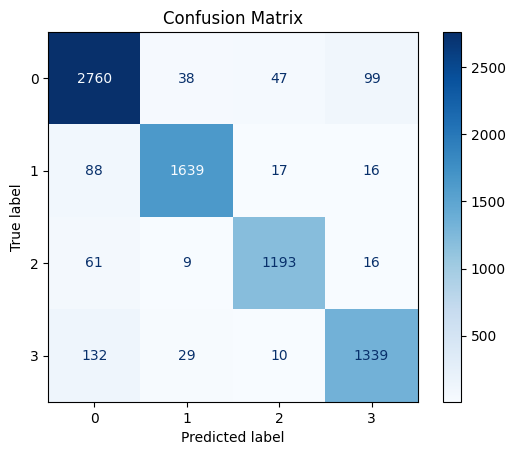

In [42]:
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2, 3])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Write a function to classify a piece of text.

In [43]:
def classify_text(text: str) -> tuple[int | str, np.ndarray]:
    tokenized_input = preprocess_texts(text)

    outputs = backbone(
        input_ids=tokenized_input['input_ids'],
        attention_mask=tokenized_input['attention_mask']
    )
        
    cls_embeddings = outputs.last_hidden_state[:, 0, :]

    predictions = model.predict(cls_embeddings)
    predicted_labels = np.argmax(predictions, axis=1)

    return LABELS[int(predicted_labels)], predictions

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [59]:
result_class = classify_text(ads['home_care'][4])

1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_150544/3462582729.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return LABELS[int(predicted_labels)], predictions


In [60]:
result_class

('Household',
 array([[0.48929223, 0.23004185, 0.20513321, 0.07553267]], dtype=float32))

# Bonus

Write a function that computes word impact on text label. 

In [60]:
ITEM_INDEX = 1

In [53]:
descriptions, labels = get_raw_data()

In [100]:
def get_words_impact(text: str) -> list[tuple[str, np.ndarray]]:
    def get_predicted_probabilities(text):
        tokenized_input = preprocess_texts(text)
    
        outputs = backbone(
            input_ids=tokenized_input['input_ids'],
            attention_mask=tokenized_input['attention_mask']
        )
            
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
        predictions = model.predict(cls_embeddings)

        return predictions

    all_sequence_predicted_probabilities = get_predicted_probabilities(text)[0]

    impacts = []
    words = text.split()

    print(words)

    for i, word in enumerate(words):
        modified_text = " ".join(words[:i] + words[i+1:])
        
        predicted_probabilities = get_predicted_probabilities(modified_text)[0]
        difference = all_sequence_predicted_probabilities - predicted_probabilities
        impacts.append((word, difference))

    return impacts

In [101]:
impacts = get_words_impact(descriptions[ITEM_INDEX])

1/1 [==============================] - 0s 12ms/step
['SAF', "'Floral'", 'Framed', 'Painting', '(Wood,', '30', 'inch', 'x', '10', 'inch,', 'Special', 'Effect', 'UV', 'Print', 'Textured,', 'SAO297)', 'Painting', 'made', 'up', 'in', 'synthetic', 'frame', 'with', 'UV', 'textured', 'print', 'which', 'gives', 'multi', 'effects', 'and', 'attracts', 'towards', 'it.', 'This', 'is', 'an', 'special', 'series', 'of', 'paintings', 'which', 'makes', 'your', 'wall', 'very', 'beautiful', 'and', 'gives', 'a', 'royal', 'touch', '(A', 'perfect', 'gift', 'for', 'your', 'special', 'ones).']
1/1 [==============================] - 0s 11ms/step


In [102]:
true_label_seq = labels[ITEM_INDEX]

0


Try to find out words that make text have a specific label.

In [118]:
def get_word_biggest_impact(label, impacts):
    words = []
    predicted_probabilities = []

    for impact in impacts:
        words.append(impact[0])
        predicted_probabilities.append(impact[1])

    words = np.array(words)
    predicted_probabilities = np.array(predicted_probabilities)

    true_label_probabilities = predicted_probabilities[:,label]
    max_impact_index = np.argwhere(true_label_probabilities > 0).reshape(-1)

    return words[max_impact_index]

In [119]:
get_word_biggest_impact(true_label_seq, impacts)

array(['Textured,', 'made', 'special', 'which', 'wall', 'and', 'royal',
       'perfect', 'special', 'ones).'], dtype='<U9')

In [107]:
descriptions[ITEM_INDEX]

"SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch (A perfect gift for your special ones)."

In [50]:
ads = {
    "home_care": [
        "Transform your home into a sanctuary with our eco-friendly cleaning solutions!",
        "Simplify your daily chores with our innovative home care products.",
        "Say goodbye to stubborn stains—welcome to effortless cleaning!",
        "Fresh scents, spotless results. Try our all-natural home care line today!",
        "Keep your home cozy and clean with our premium fabric care solutions.",
        "Cleaning made easy! Discover tools that save you time and effort.",
        "Your perfect cleaning companion awaits—shop now and save!",
        "Make every corner of your home shine with our expert care products.",
        "Gentle on surfaces, tough on dirt. Choose smart cleaning!",
        "Breathe easier—experience cleaner air with our advanced purifiers."
    ],
    "electronics": [
        "Upgrade your tech game with the latest gadgets at unbeatable prices!",
        "Experience cinema-quality sound and visuals at home—shop our electronics now!",
        "Stay connected with cutting-edge devices designed for your lifestyle.",
        "The future is here: discover next-gen smart home electronics today!",
        "Elevate your productivity with our state-of-the-art laptops and accessories.",
        "Capture life’s best moments in HD—find the perfect camera for you.",
        "Stream, surf, and play with lightning-fast devices. Shop now!",
        "Power meets elegance in our premium smartphone collection.",
        "Stay ahead with innovative wearables that fit your lifestyle.",
        "Save big on top-brand electronics—limited time only!"
    ],
    "books": [
        "Embark on your next adventure—browse our best-selling novels now!",
        "Expand your horizons with inspiring non-fiction books.",
        "Cozy up with the perfect story—find your new favorite read today!",
        "From thrillers to romance, we’ve got every genre covered.",
        "Feed your mind and soul—shop our curated book collections.",
        "Unlock new worlds—explore the latest fantasy and sci-fi titles!",
        "Knowledge is power—find the perfect book to learn and grow.",
        "Love paperbacks? Check out our exclusive deals on top reads!",
        "Discover timeless classics and modern masterpieces in one place.",
        "Books that move you—shop stories that stay with you forever."
    ],
    "clothing": [
        "Step out in style with our trendy and affordable clothing!",
        "Comfort meets fashion—shop our best-selling casual wear.",
        "Elevate your wardrobe with timeless classics and bold designs.",
        "Find your perfect fit—explore our new arrivals in all sizes!",
        "Get cozy this season with our soft and stylish knitwear.",
        "Make a statement—shop bold and unique fashion pieces now!",
        "From work to weekend, we’ve got the outfits you’ll love.",
        "Dress your best without breaking the bank—shop now!",
        "Refresh your look with our exclusive deals on seasonal must-haves.",
        "Confidence starts with the right outfit—find yours today!"
    ]
}